소스 위치: https://www.kaggle.com/code/agileteam/tutorial-t2-2-python/notebook

<문제>
제품 배송 시간에 맞춰 배송되었는지 예측모델 만들기
학습용 데이터 (X_train, y_train)을 이용하여 배송 예측 모형을 만든 후, 이를 평가용 데이터(X_test)에 적용하여 얻은 예측값을 다음과 같은 형식의 CSV파일로 생성하시오(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 채점)

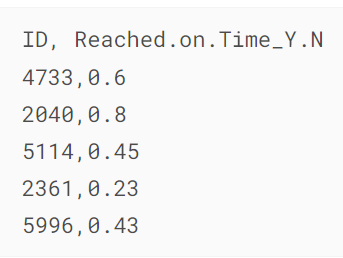

(유의사항)

성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, 피처엔지니어링, 분류알고리즘, 하이퍼파라미터 튜닝, 모형 앙상블 등이 수반되어야 한다.
수험번호.csv파일이 만들어지도록 코드를 제출한다.
제출한 모델의 성능은 ROC-AUC형태로 읽어드린다.

In [36]:
# 이 코드는 시험장에서 주어짐 
import pandas as pd
X_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")
X_test = pd.read_csv("./X_test.csv")

In [37]:
X_train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,4000,B,Ship,3,4,134,3,high,F,6,5680
1,9560,F,Ship,4,3,173,3,medium,M,5,5331
2,2650,B,Ship,2,1,192,3,high,M,46,3206
3,4844,F,Ship,6,5,284,4,medium,M,8,5346
4,9602,F,Flight,3,1,246,3,low,F,10,4707


In [38]:
y_train.head()

,ID,Reached.on.Time_Y.N
0,4000,0
1,9560,1
2,2650,1
3,4844,1
4,9602,1


In [39]:
X_test.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,4733,C,Ship,5,5,250,2,medium,M,10,5475
1,2040,F,Road,5,2,202,3,medium,M,34,3885
2,5114,F,Ship,5,4,154,2,low,F,5,5528
3,2361,A,Ship,6,4,209,5,low,F,53,3169
4,5996,F,Ship,6,1,250,4,low,M,4,1018


In [40]:
print(X_train.shape, y_train.shape, X_test.shape)

(8799, 11) (8799, 2) (2200, 11)


In [41]:
# 원래는 목적변수가 Imbalanced data 가 아닌지 확인하는 작업이 필요함. 
y_train['Reached.on.Time_Y.N'].value_counts()

1    5251
0    3548
Name: Reached.on.Time_Y.N, dtype: int64

In [42]:
# 결측치 확인 
X_train.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
dtype: int64

In [43]:
X_test.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
dtype: int64

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 756.3+ KB


In [45]:
# object type 중심으로 확인하고..
X_train.describe(include ='object')

# 일단, 범주형 변수는 버려보고..(그래도 성능이 괜찮은 경우 많음..)
# 만일 unique 가 너무 많으면? 변수 버리거나 재 그룹화
#                     5개 이하면? one hot 인코딩으로 수치화 

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,8799,8799,8799,8799
unique,5,3,3,2
top,F,Ship,low,F
freq,2941,5913,4247,4456


In [46]:
# ID는 학습에 쓰지 않지만, 일단 빼 놓아서 나중에 쓰일 수 있음. 
X_train_id = X_train.pop('ID')
X_test_id  =  X_test.pop('ID')

In [48]:
# 범주형 변수는 삭제 (또는 One Hot 인코딩)
X_train2 = X_train.drop(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], axis=1)
X_test2  =  X_test.drop(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], axis=1)

In [50]:
# 1) train 데이터로 학습/평가 
# 2) train을 hold out 해서 학습/평가 분리 
# 3) train을 Cross Validation 해서 평가 

# 우선 가장 쉬운 것 부터 
# now we have.. X_train2, y_train, X_test2
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train2, y_train['Reached.on.Time_Y.N'])

RandomForestClassifier()

In [70]:
train_pred = model.predict_proba(X_train2)

In [71]:
# train에서 모델/평가 다 해 버림. 
roc_auc_score(y_train['Reached.on.Time_Y.N'], train_pred[:,1])

1.0

In [72]:
test_pred = model.predict_proba(X_test2)


submission = pd.DataFrame({
        "ID": X_test_id,
        "Reached.on.Time_Y.N": test_pred[:,1]
    })
submission.head()

,ID,Reached.on.Time_Y.N
0,4733,0.28
1,2040,1.00
2,5114,0.71
3,2361,0.99
4,5996,0.44


In [75]:
submission.to_csv('submission.csv', index=False)
pd.read_csv("./submission.csv").head()

,ID,Reached.on.Time_Y.N
0,4733,0.28
1,2040,1.00
2,5114,0.71
3,2361,0.99
4,5996,0.44
